In [1]:
import numpy as np
from astropy.modeling import models, fitting
from spectres import spectres
from scipy import signal 
# from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib widget

In [7]:
def normalise(wavelength, flux):
    """
    normalise the spectrum.
    
    Parameters:
    wavelength (array): Wavelength array
    flux (array): Flux array
    
    Returns:
    normalised_flux (array): normalised flux array
    continuum (array): Continuum flux array
    """
    wavelength_centered = wavelength - wavelength.mean()
    
    # Assumes wavelength array is in Angstroms and fluctuations are in a 100 Angstrom scale
    order = int((wavelength[-1] - wavelength[0]) / 100)

    # Fit polynomial to continuum
    poly_model = models.Polynomial1D(degree=order)
    fitter = fitting.LinearLSQFitter()
    best_fit_poly = fitter(poly_model, wavelength_centered, flux)
    
    continuum = best_fit_poly(wavelength_centered)
    
    normalised_flux = flux / continuum
    return normalised_flux, continuum

def xcor(wave_temp, flux_temp, wave_obs, flux_obs):
    """
    Derive radial velocities from cross-correlation.
    
    Parameters:
    wave_temp (array): Template wavelength array
    flux_temp (array): Template flux array
    wave_obs (array): Observed wavelength array
    flux_obs (array): Observed flux array
    
    Returns:
    z (float): Redshift
    rv (float): Radial velocity in km/s
    """
    c_in_kms = 299792.46
    
    # Combine wavelength arrays and create a logarithmic wavelength grid
    combined_wave = np.append(wave_temp, wave_obs)
    log_wave_grid = np.logspace(np.log10(combined_wave.min()), np.log10(combined_wave.max()), len(combined_wave))

    # Resample template spectrum
    log_wave_mask_temp = (wave_temp[1] <= log_wave_grid) & (log_wave_grid <= wave_temp[-2])
    log_wave_temp = log_wave_grid[log_wave_mask_temp]
    resampled_flux_temp = spectres(log_wave_temp, wave_temp, flux_temp)

    # Resample observed spectrum
    log_wave_mask_obs = (wave_obs[1] <= log_wave_grid) & (log_wave_grid <= wave_obs[-2])
    log_wave_obs = log_wave_grid[log_wave_mask_obs]
    resampled_flux_obs = spectres(log_wave_obs, wave_obs, flux_obs)
    
    # normalise flux
    total_flux_temp = np.dot(resampled_flux_temp, np.gradient(log_wave_temp))
    total_flux_obs = np.dot(resampled_flux_obs, np.gradient(log_wave_obs))

    resampled_flux_temp /= total_flux_temp
    resampled_flux_obs /= total_flux_obs
    
    normalised_flux_temp, _ = normalise(log_wave_temp, resampled_flux_temp)
    normalised_flux_obs, _ = normalise(log_wave_obs, resampled_flux_obs)

    # Cross-correlate
    correlation = signal.correlate(normalised_flux_obs, normalised_flux_temp, mode="full")
    
    # Calculate redshift
    # lag = np.argmax(correlation) - (len(normalised_flux_temp) - 1)
    z = -1 * ((log_wave_temp[-1 * np.argmax(correlation)] / log_wave_obs[0]) - 1)

    rv = z * c_in_kms
    # print(f'z: {z:.4f}, RV: {rv:.1f} km/s')
    # print(lag)

    return z, rv

# Function to add noise to the spectrum
def add_noise(flux, flux_uncertainty):
    """Add Gaussian noise to the flux based on its uncertainty."""
    return flux + np.random.normal(0, flux_uncertainty)

In [3]:
# Generate fake data
rng = np.random.default_rng(0)
RV = 150 #in km/s #obs. redshift
c_in_kms = 299792.46

#template
wl1 = np.linspace(-5., 5., 200)
flx1 = 3 * np.exp(-0.5 * (wl1 - 1.3)**2 / 0.8**2)
# flx1 += rng.normal(0., 0.2, wl1.shape) #template noise
wl1+=3000

#obs
wl2 = np.linspace(-2., 8.5, 300)
flx2 = 3 * np.exp(-0.5 * (wl2 - 1.3)**2 / 0.8**2) #+(10*wl2 + 4)
flx2 += rng.normal(0., 0.2, wl2.shape) #obs. noise+10
flx2 *=2
wl2 +=3000
wl2 *=(1+RV/c_in_kms) #redshift obs.

In [8]:
# Copy the original data to new variables
wave_obs, flux_obs, wave_temp, flux_temp = wl2.copy(), flx2.copy(), wl1.copy(), flx1.copy()

# Perform the cross-correlation on the original data
z, rv = xcor(wave_temp, flux_temp, wave_obs, flux_obs)
print(f'z: {z:.4f}, RV: {rv:.1f} km/s (single experiment)')

# Number of realizations for Monte Carlo
n_realizations = 100
velocities = []

for _ in range(n_realizations):
    # Add noise to the observed flux
    noisy_flux_obs = add_noise(flux_obs, np.sqrt(np.abs(flux_obs)))
    
    # Perform the cross-correlation with the noisy flux
    _, velocity = xcor(wave_temp, flux_temp, wave_obs, noisy_flux_obs)
    
    # Collect the velocity result
    velocities.append(velocity)

# Estimate the uncertainty as the standard deviation of the radial velocities
velocity_uncertainty = np.std(velocities)
median_velocity = np.median(velocities)

print(f'RV: {median_velocity:.1f} ± {velocity_uncertainty:.1f} km/s ({n_realizations} noisy experiments)')

z: 0.0005, RV: 147.1 km/s (single experiment)
RV: 147.1 ± 4.9 km/s (100 noisy experiments)


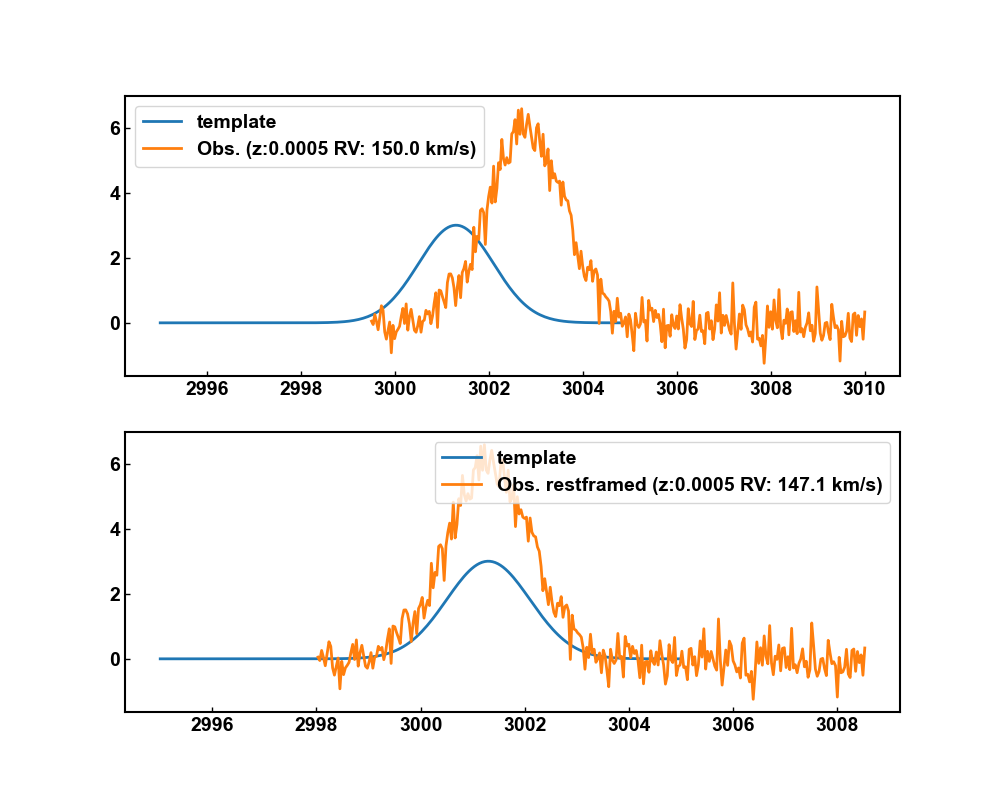

In [9]:
f,ax = plt.subplots(nrows=2,figsize=(10,8))
ax[0].plot(wl1,flx1,lw=2,label='template')
ax[0].plot(wl2,flx2,lw=2,label='Obs. (z:{:.4f} RV: {:.1f} km/s)'.format(RV/c_in_kms,RV))
ax[0].legend()

ax[1].plot(wl1,flx1,lw=2,label='template')
ax[1].plot(wl2/(1+z),flx2,lw=2,label='Obs. restframed (z:{:.4f} RV: {:.1f} km/s)'.format(z,z*c_in_kms))
ax[1].legend()